In [20]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg.gitmonai@0.8.1+271.g07de215c
!pip install nibabel==3.1.1
!pip install tqdm==4.63.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

  Cloning https://github.com/Project-MONAI/MONAI to c:\users\sathy\appdata\local\temp\pip-req-build-q4q8ww0h


  Running command git clone --filter=blob:none --quiet https://github.com/Project-MONAI/MONAI 'C:\Users\sathy\AppData\Local\Temp\pip-req-build-q4q8ww0h'
  fatal: Out of memory, malloc failed (tried to allocate 1316134912 bytes)
  fatal: Could not read from remote repository.

  Please make sure you have the correct access rights
  and the repository exists.
  error: subprocess-exited-with-error
  
  git clone --filter=blob:none --quiet https://github.com/Project-MONAI/MONAI 'C:\Users\sathy\AppData\Local\Temp\pip-req-build-q4q8ww0h' did not run successfully.
  exit code: 128
  
  See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

git clone --filter=blob:none --quiet https://github.com/Project-MONAI/MONAI 'C:\Users\sathy\AppData\Local\Temp\pip-req-build-q4q8ww0h' did not run successfully.
exit code: 128

See above for output.

note: This error originates from a subprocess, and is likely not 

In [21]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2228
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b287dfc6a7c397523ba67e10a0436099fb0a44f7
MONAI __file__: C:\Users\sathy\OneDrive\Documents\GitHub\Multi-Modality-Abdominal-Multi-Organ-Segmentation-Challenge-2022\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 3.1.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu113
tqdm version: 4.63.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [22]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\sathy\AppData\Local\Temp\tmpq8a6y1zk


In [23]:
num_samples = 1

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [24]:
import os
print(os.getcwd())
data_dir = ""
split_JSON = "monai_labels.json"

datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=0,
    cache_rate=0.0,
    num_workers=2,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True,
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=0,
 cache_rate=0.0, num_workers=2
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True
)

C:\Users\sathy\OneDrive\Documents\GitHub\Multi-Modality-Abdominal-Multi-Organ-Segmentation-Challenge-2022\monai_training


amos_0217.nii.gz
image shape: torch.Size([1, 235, 216, 306]), label shape: torch.Size([1, 235, 216, 306])


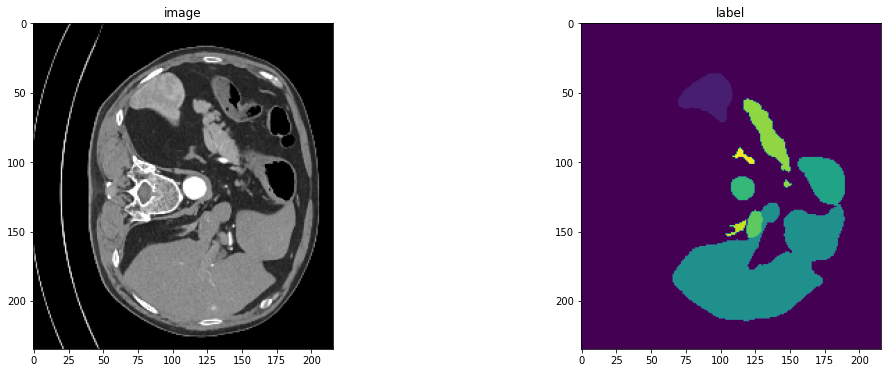

In [25]:
# !pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

size = (64, 64, 64)
slice_map = {
    "amos_0217.nii.gz": 170,
    "amos_0224.nii.gz": 230,
    "amos_0225.nii.gz": 204,
    "amos_0226.nii.gz": 204,
    "amos_0230.nii.gz": 204,
    "amos_0231.nii.gz": 204,
    "amos_0235.nii.gz": 204,
    "amos_0237.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
print(img_name)
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [26]:
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=size,
    in_channels=1,
    out_channels=16,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [27]:
print(torch.cuda.is_available())
weight = torch.load("./model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

True
Using pretrained self-supervied Swin UNETR backbone weights !


In [28]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [29]:
from GPUtil import showUtilization as gpu_usage

print("Initial GPU Usage")
gpu_usage()
torch.cuda.empty_cache()
print('cache empty')
gpu_usage()

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, size, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    torch.cuda.empty_cache()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    torch.cuda.empty_cache()
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=16)
post_pred = AsDiscrete(argmax=True, to_onehot=16)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 30% | 88% |
cache empty
| ID | GPU | MEM |
------------------
|  0 | 30% | 47% |


Validate (X / X Steps) (dice=X.X):   0%|          | 0/40 [00:00<?, ?it/s]C:\Users\sathy\OneDrive\Documents\GitHub\Multi-Modality-Abdominal-Multi-Organ-Segmentation-Challenge-2022\venv\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")

Training (500 / 30000 Steps) (loss=1.52177):  11%|█         | 13/122 [06:53<3:16:12, 108.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10662589967250824 Current Avg. Dice: 0.10662589967250824


Training (1000 / 30000 Steps) (loss=1.62466):  20%|█▉        | 24/122 [06:08<25:05, 15.36s/it]


RuntimeError: CUDA out of memory. Tried to allocate 674.00 MiB (GPU 0; 11.00 GiB total capacity; 7.18 GiB already allocated; 0 bytes free; 9.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF